<a href="https://colab.research.google.com/github/takhanhvy/Classification-des-categories-de-nouvelles-BBC-avec-SVM/blob/main/Classification_des_cat%C3%A9gories_de_nouvelles_BBC_avec_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification des catégories de nouvelles BBC avec SVM

Le TP consiste à entraîner le modèle de machine learning supervisé SVM (Support Vector Machine) pour prédire la catégorie des nouvelles BBC à partir du contenu des articles.

Les objectifs principaux sont :
- Comprendre le concept et le principe de fonctionnement des Machines à Vecteurs de
Support (SVM).
- Appliquer des techniques de prétraitement du texte pour des tâches de NLP en
utilisant NLTK.
- Préparer les données textuelles pour l’apprentissage supervisé en combinant le titre et
le contenu, en tokenisant, en lemmatisant et en supprimant les stop words.
- Convertir les données textuelles en représentations numériques à l’aide de la
vectorisation TF-IDF.
- Entraîner et évaluer un modèle SVM pour des tâches de classification de texte.
- Interpréter les sorties du modèle et évaluer les performances de classification en
utilisant des métriques appropriées.

**Réalisé par : TA Khanh Vy**  
Dans le cadre du cours "Natural Language Processing" du M1 Mastère Data Engineering (Efrei) dirigé par Mme. Sarah Malaeb

# Jeu de données

Le jeu de données BBC News inclut :
- category  
C’est la variable cible (l’étiquette).
Elle indique le type d’article de presse (par exemple, business, politique, sport,
technologie, divertissement).
- filename  
Le nom de fichier original du document texte (par exemple, 163.txt).
Chaque fichier contient un article de presse. Il s’agit uniquement d’un identifiant, non utile pour la classification en elle-même.  
- title  
Le titre de l’article de presse.  
Exemple : « US data sparks inflation worries ».
- content  
Le texte principal de l’article.  
Exemple : « Wholesale prices in the US rose at the fastest … ».  
Nous travaillerons avec les nouvelles BBC pour 2004‑2005 disponibles sur : https://www.kaggle.com/hgultekin/bbcnewsarchive

# Chargement des données

In [64]:
# Imports des bibliothèques principales

import numpy as np
import pandas as pd

# NLTK pour le prétraitement du texte
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Scikit-learn pour la vectorisation et le modèle de Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC       # SVM linéaire
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt        # Pour visualiser la matrice de confusion
import seaborn as sns                  # Pour rendre la matrice de confusion plus lisible

# Téléchargement des ressources NLTK (à exécuter une fois)
nltk.download('punkt')       # Tokenizer décompose un text en liste des phrases
nltk.download('wordnet')     # Base de données WordNet pour la lemmatisation
nltk.download('stopwords')   # Liste de stop words
nltk.download('omw-1.4')     # Ressources supplémentaires pour WordNet
nltk.download('punkt_tab')   # Ressource manquante pour la tokenisation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bbc-news-data.csv to bbc-news-data.csv


In [ ]:
# Chargement du jeu de données
df = pd.read_csv("bbc-news-data.csv", sep='\t')

# Aperçu des premières lignes
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


# Prétraitement du texte (Text Preprocessing)

In [39]:
# Combiner le titre et le contenu de l’article dans un seul champ
df['raw_text'] = df['title'] + " " + df['content']
raw_text = df['raw_text'].to_list()

In [41]:
# Mettre le texte en minuscules
raw_text = [text.lower() for text in raw_text]

In [45]:
# Tokenization - Découper en tokens (mots)
tokens = [word_tokenize(text) for text in raw_text]

In [48]:
# Filtrage : Ne conserve que les lettres (supprimer ponctuation et chiffres)
tokens = [[word for word in doc_tokens if re.match(r'^[a-z]+$', word)] for doc_tokens in tokens]

In [49]:
# Supprimer les stop words
stop_words = set(stopwords.words('english'))
tokens = [[word for word in doc_tokens if word not in stop_words] for doc_tokens in tokens]

In [59]:
# Lemmatisation

# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatiser les tokens
tokens = [[lemmatizer.lemmatize(word) for word in doc_tokens] for doc_tokens in tokens]

In [70]:
# reconstruction d'un corpus propre à partir des tokens lemmatisés pour la vectorization TF-IDF
corpus = [" ".join(doc_tokens) for doc_tokens in tokens]

# apercu des 5 premiers tokens lemmatisés
print(corpus[:5])

['ad sale boost time warner profit quarterly profit u medium giant timewarner jumped three month december firm one biggest investor google benefited sale internet connection higher advert sale timewarner said fourth quarter sale rose profit buoyed gain offset profit dip warner bros less user aol time warner said friday owns google internet business aol mixed fortune lost subscriber fourth quarter profit lower preceding three quarter however company said aol underlying profit exceptional item rose back stronger internet advertising revenue hope increase subscriber offering online service free timewarner internet customer try sign aol existing customer broadband timewarner also restate result following probe u security exchange commission sec close concluding time warner fourth quarter profit slightly better analyst expectation film division saw profit slump helped flop alexander catwoman sharp contrast third final film lord ring trilogy boosted result timewarner posted profit performanc

# Vectorisation avec TF-IDF

In [72]:
# initialisation du vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# X : texte vectorisé
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

# y : variable cible
y = df['category']

# Séparation Train / Test

In [84]:
# Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.20)

# Entraînement du modèle SVM

In [85]:
# Initialisation du classificateur SVM linéaire
svm_clf = LinearSVC()

# Entraînement du modèle sur les données d'entraînement vectorisées
svm_clf.fit(X_train, y_train)

LinearSVC()

# Test et évaluation du modèle

In [90]:
# Prédiction des catégories pour l'ensemble de test
y_pred = svm_clf.predict(X_test)

# Afficher quelques paires (prédiction, vraie valeur)
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.values.reshape(len(y_test),1)),1))


In [87]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy sur l'ensemble de test : {acc:.4f}")

Accuracy sur l'ensemble de test : 0.9865


L’accuracy obtenue sur l’ensemble de test est de 0,9865, soit environ 98,65 % de bonnes prédictions.
Cela signifie que le modèle SVM classe correctement presque 99 articles sur 100.

[[105   1   1   0   1]
 [  0  74   1   0   0]
 [  1   0  76   1   0]
 [  0   0   0 100   0]
 [  0   0   0   0  84]]


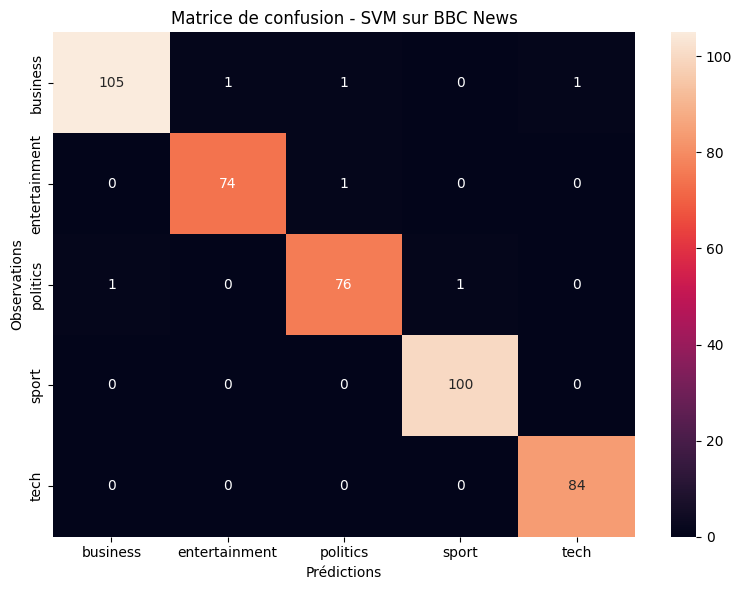

In [89]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=svm_clf.classes_)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=svm_clf.classes_,
            yticklabels=svm_clf.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Observations')
plt.title('Matrice de confusion - SVM sur BBC News')
plt.tight_layout()
plt.show()

La matrice de confusion montre que les valeurs sont très concentrées sur la diagonale, ce qui signifie que la majorité des articles sont bien classés dans leur vraie catégorie.

Les erreurs sont rares et se produisent principalement entre des catégories sémantiquement proches : quelques articles business classés en politics ou tech ou un petit nombre d’articles politics confondus avec business ou sport.

Les catégories sport et entertainment sont quasiment sans erreurs, ce qui confirme qu’elles ont un vocabulaire très spécifique.

In [83]:
# Rapport de classification détaillé
print('Rapport de classification :')
print(classification_report(y_test, y_pred))

Rapport de classification :
               precision    recall  f1-score   support

     business       0.98      0.93      0.95       111
entertainment       0.99      1.00      0.99        74
     politics       0.94      0.98      0.96        86
        sport       0.99      0.99      0.99       108
         tech       0.96      0.98      0.97        66

     accuracy                           0.97       445
    macro avg       0.97      0.98      0.97       445
 weighted avg       0.97      0.97      0.97       445



D’après le rapport de classification :

- business

  * precision = 0,98, recall = 0,93, f1 = 0,95
  * Le modèle est très précis quand il prédit “business” (il se trompe rarement),
  mais son rappel est un peu plus faible : ~7 % des articles réellement “business” sont classés dans une autre catégorie.
  On le voit dans la matrice de confusion : quelques articles “business” sont prédits comme entertainment, politics ou tech.

- entertainment

  * precision = 0,99, recall = 1,00, f1 = 0,99
  * Catégorie presque parfaite : tous les articles “entertainment” du test sont correctement retrouvés (recall = 1,00) et le modèle ne crée quasiment pas de faux positifs.

- politics

  * precision = 0,94, recall = 0,98, f1 = 0,96
  * Le modèle retrouve presque tous les articles de politique (rappel élevé),
  mais il arrive qu’il étiquette à tort quelques articles d’autres catégories comme “politics”, d’où une précision légèrement plus faible.

- sport

  * precision = 0,99, recall = 0,99, f1 = 0,99
  * Performances quasi parfaites : la thématique sport est très bien captée par le modèle, certainement grâce à un vocabulaire très spécifique (score, match, goal, etc.).

- tech

  * precision = 0,96, recall = 0,98, f1 = 0,97
  * Très bons résultats également. Quelques rares confusions avec d’autres catégories (souvent “business”), ce qui est logique pour des articles à la frontière entre économie et technologie.

Les moyennes macro et weighted (≈ 0,97–0,98) confirment que les performances sont équilibrées entre les catégories et qu’il n’y a pas de classe clairement “sacrifiée”.

## Erreurs et biais éventuels dans la classification


Même si l’accuracy globale du modèle est très élevée (environ **98,65 %**), l’analyse de la matrice de confusion et du rapport de classification permet de repérer quelques erreurs et légers biais. La catégorie `business` est celle qui pose le plus de difficultés au modèle. Sa précision est très bonne (0,98), mais son rappel est un peu plus faible (0,93). Concrètement, lorsqu’un article est prédit comme `business`, le modèle a presque toujours raison, mais il ne parvient pas à retrouver tous les articles réellement `business`. Une petite partie d’entre eux est classée dans d’autres catégories. La matrice de confusion montre d’ailleurs que certains articles `business` sont parfois prédits comme `entertainment`, `politics` ou `tech`, ce qui suggère que, en cas d’hésitation, le modèle a tendance à les basculer vers des classes voisines plutôt qu’à les laisser dans `business`.

Les confusions observées concernent principalement des catégories **sémantiquement proches**. On voit par exemple que quelques articles de `politics` sont classés en `business` ou en `sport`. Ce type d’erreur est cohérent avec le contenu : certains articles parlent de politique économique ou de politique sportive, et le vocabulaire employé peut ressembler à celui d’autres rubriques. De la même manière, les rares confusions entre `business` et `tech` peuvent provenir d’articles qui traitent de technologies d’entreprise ou de marchés technologiques, à la frontière entre économie et technologie. Le modèle semble donc surtout éprouver des difficultés sur les frontières entre classes proches, plutôt que sur des catégories très différentes.

À l’inverse, les catégories `entertainment`, `sport` et `tech` sont globalement très bien reconnues. Les scores de précision et de rappel sont tous supérieurs à 0,96, et la matrice de confusion montre presque aucune erreur pour `sport` et seulement un cas isolé pour `entertainment`. Cela indique que ces thèmes possèdent un vocabulaire très spécifique (noms de joueurs, de films, de clubs, termes sportifs ou techniques, etc.) que la combinaison TF-IDF + SVM parvient à capturer de manière très efficace.  

On ne constate pas de biais fort en faveur d’une seule classe : les données de test sont relativement équilibrées entre les différentes catégories, et les erreurs ne se concentrent pas toutes sur la même étiquette prédite. Autrement dit, le modèle ne semble pas “tout” classer dans une catégorie dominante, ce qui est un bon signe du point de vue de l’équité entre classes.

Enfin, il faut garder en tête certaines limites possibles. Le modèle est entraîné sur des articles de la BBC datant de 2004–2005 : il est donc probablement adapté à ce style éditorial et à cette période, mais pourrait être moins performant sur d’autres sources d’actualités ou sur des textes plus récents. De plus, certaines nouvelles sont elles-mêmes ambiguës ou hybrides (par exemple à la croisée de l’économie et de la politique), ce qui les rend difficiles à classer même pour un humain. Les rares erreurs observées reflètent aussi cette ambiguïté naturelle des contenus.


# Conclusion

Globalement, le modèle SVM avec TF-IDF offre une excellente capacité de généralisation sur ce dataset :

- Accuracy proche de 99 %

- Très bons scores de precision, recall et F1-score pour toutes les classes

- Très peu de confusions, principalement entre catégories proches (business/politics/tech)

On peut donc conclure que la chaîne de traitement (prétraitement NLTK + vectorisation TF-IDF + SVM linéaire) est très adaptée à la classification des articles BBC.  

Les rares erreurs observées sont cohérentes avec la proximité thématique de certaines catégories et ne révèlent pas de biais majeur du modèle.